# Mass-Spring Crane Simulation

Interactive 3D simulation of complex mass-spring systems using the myASC-ODE framework.



In [1]:
import sys
import os


try:

    current_dir = os.path.dirname(os.path.realpath(__file__))
except NameError:

    current_dir = os.getcwd()


project_root = os.path.join(current_dir, '..', '..')
mechsystem_path = os.path.join(project_root, 'mechsystem')
build_path = os.path.join(project_root, 'build', 'mechsystem')

sys.path.insert(0, mechsystem_path)
sys.path.insert(0, build_path)


sys.path.append('/Users/constantinpierer/Documents/TU_Wien/Technische_Mathematik/7.Semester/Repositorys/myASC-ODE/mechsystem')
sys.path.append('/Users/constantinpierer/Documents/TU_Wien/Technische_Mathematik/7.Semester/Repositorys/myASC-ODE/build/mechsystem')



from mass_spring import *
from pythreejs import *

import numpy as np
import matplotlib.pyplot as plt
from time import sleep

## Setup

The crane consists of:

- 3 fixed base weights
- 4 movable weights** connected by joints and beams
- 1 load, attached via a spring (simulating vertical pulling forces)


The system is influenced by:
- Gravitational force
- Wind force


In [2]:
mss = MassSpringSystem3d()

# we simulate wind with force in y direction
mss.gravity = (0, 0.1, -9.81)

# Base (fixed)
base = mss.add(Fix((0, 0, 0)))

# anti weight
second_base = mss.add(Fix((-2, 0, 0)))
third_base = mss.add(Fix((0, -2, 0)))
#fourth_base = mss.add(Fix((0, 2, 0)))

# Tower masses
tower_bottom = mss.add(Mass(0.5, (0, 0, 2), (0, 0, 0)))
tower_top = mss.add(Mass(0.1, (0, 0, 4), (0, 0, 0)))

# Boom masses
boom_mid = mss.add(Mass(0.1, (2, 0, 4), (0, 0, 0)))
boom_end = mss.add(Mass(0.1, (4, 0, 4), (0, 0, 0)))

# Load mass

load = mss.add(Mass(0.001, (4, 0, 2), (0, 0, 0)))

# Tower joints
mss.add(Joint(2.0, (base, tower_bottom)))
mss.add(Joint(2.0, (tower_bottom, tower_top)))

# Anti-mass joint
mss.add(Joint(np.sqrt(8), (second_base, tower_bottom)))
mss.add(Joint(np.sqrt(20), (second_base, tower_top)))
mss.add(Joint(np.sqrt(8), (third_base, tower_bottom)))
mss.add(Joint(np.sqrt(20), (third_base, tower_top)))
#mss.add(Joint(2.0, (anti_mass, base)))

# additional diagonal joints
mss.add(Joint(np.sqrt(8), (tower_bottom, boom_mid)))
mss.add(Joint(np.sqrt(20), (tower_bottom, boom_end)))

# Boom joints
mss.add(Joint(2.0, (tower_top, boom_mid)))
mss.add(Joint(2.0, (boom_mid, boom_end)))


mss.add(Spring(10.0, 2.0, (boom_end, load))) 


0

In [3]:

masses = []
for i, m in enumerate(mss.masses):
    if i < 2:  
        color = 'blue'
        size = 0.1
    elif i < 4:  
        color = 'orange'
        size = 0.08
    else:  
        color = 'red'
        size = 0.15
        
    masses.append(
        Mesh(SphereBufferGeometry(size, 16, 16),
             MeshStandardMaterial(color=color),
             position=(m.pos[0], m.pos[1], m.pos[2])))

# Fixed points
fixes = []
for f in mss.fixes:
    fixes.append(
        Mesh(SphereBufferGeometry(0.2, 16, 16),
             MeshStandardMaterial(color='black'),
             position=(f.pos[0], f.pos[1], f.pos[2])))

# Joints (rigid beams)
jointpos = []
for j in mss.joints:
    pA = mss[j.connectors[0]].pos
    pB = mss[j.connectors[1]].pos
    jointpos.append([[pA[0], pA[1], pA[2]], [pB[0], pB[1], pB[2]]])

joints = None
if jointpos:
    jointgeo = LineSegmentsGeometry(positions=jointpos)
    beam_material = LineMaterial(linewidth=3, color='gray')
    joints = LineSegments2(jointgeo, beam_material)

# Springs (more or less a flexible cables)
springpos = []
for s in mss.springs:
    pA = mss[s.connectors[0]].pos
    pB = mss[s.connectors[1]].pos
    springpos.append([[pA[0], pA[1], pA[2]], [pB[0], pB[1], pB[2]]])

springs = None
if springpos:
    springgeo = LineSegmentsGeometry(positions=springpos)
    spring_material = LineMaterial(linewidth=4, color='green')
    springs = LineSegments2(springgeo, spring_material)

axes = AxesHelper(2)


In [4]:
view_width = 800
view_height = 600


camera = PerspectiveCamera(position=[1, -6, 8], aspect=view_width/view_height)
key_light = DirectionalLight(position=[5, 10, 5], intensity=1.0)
ambient_light = AmbientLight(intensity=0.5)

scene_objects = [*masses, *fixes, axes, camera, key_light, ambient_light]
if joints:
    scene_objects.append(joints)
if springs:
    scene_objects.append(springs)

scene = Scene(children=scene_objects)
controller = OrbitControls(controlling=camera)
renderer = Renderer(camera=camera, scene=scene, controls=[controller], width=view_width, height=view_height)


renderer

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, position=(1.0, -6.0, 8.0), projectionMatrix=(1.0,…

## Displacement Analysis

The simulation monitors three types of displacements of the crane load:

### Primary Motion Patterns:
- Vertical displacement (Z-direction): Load moves up and down due to spring oscillations and gravitational settling
- Horizontal displacement (Y-direction): Load shifts sideways due to wind force (simulated as gravity component in Y)
- Lateral displacement (X-direction): Secondary motion from structural coupling and boom dynamics

### Wind Effect Analysis:
The wind force (applied as 0.1 m/s² in Y-direction) causes the load to drift horizontally while maintaining vertical oscillations. This creates a characteristic trajectory showing both:
- Primary vertical bouncing motion from the spring-mass system
- Secondary horizontal drift from wind loading

The vibration analysis focuses on the Y-direction displacement RMS to quantify how much the wind is shifting the load from its equilibrium position.

In [5]:
# Crane simulation with vibration monitoring (beatiful vizualization in cooparation with gemini :) )
load_positions = []
tower_top_positions = []
boom_end_positions = []
time_steps = []

# Vibration metrics
displacement_amplitudes = []
velocity_history = []

print("Starting crane simulation with vibration analysis...")
print("Monitoring critical points: Load mass, Tower top, Boom end")
print("Vibration thresholds: LOW <0.05m | MODERATE 0.05-0.1m | HIGH >0.1m")
print("-" * 60)

for i in range(150):
    try:
        # Run simulation step
        mss.simulate(0.01, 80)  
        
        # Update visual positions
        for m, mvis in zip(mss.masses, masses):
            mvis.position = (m.pos[0], m.pos[1], m.pos[2])

        # Update joint visualization
        if joints:
            jointpos = []
            for j in mss.joints:
                pA = mss[j.connectors[0]].pos
                pB = mss[j.connectors[1]].pos
                jointpos.append([[pA[0], pA[1], pA[2]], [pB[0], pB[1], pB[2]]])
            joints.geometry = LineSegmentsGeometry(positions=jointpos)

        # Update spring visualization
        if springs:
            springpos = []
            for s in mss.springs:
                pA = mss[s.connectors[0]].pos
                pB = mss[s.connectors[1]].pos
                springpos.append([[pA[0], pA[1], pA[2]], [pB[0], pB[1], pB[2]]])
            springs.geometry = LineSegmentsGeometry(positions=springpos)

        # Collect position and vibration data
        current_time = i * 0.01
        time_steps.append(current_time)
        
        # Critical point positions
        load_pos = mss.masses[-1].pos  # Load mass
        tower_top_pos = mss.masses[1].pos  # Tower top 
        boom_end_pos = mss.masses[3].pos  # Boom end
        
        load_positions.append([load_pos[0], load_pos[1], load_pos[2]])
        tower_top_positions.append([tower_top_pos[0], tower_top_pos[1], tower_top_pos[2]])
        boom_end_positions.append([boom_end_pos[0], boom_end_pos[1], boom_end_pos[2]])
        
        # Calculate vibration metrics
        if len(load_positions) > 10:
            # RMS displacement over last 10 steps
            recent_y = [pos[1] for pos in load_positions[-10:]]
            mean_y = np.mean(recent_y)
            rms_displacement = np.sqrt(np.mean([(y - mean_y)**2 for y in recent_y]))
            displacement_amplitudes.append(rms_displacement)
            
            # Velocity estimation via finite difference
            if len(load_positions) > 1:
                velocity = np.linalg.norm(np.array(load_pos) - np.array(load_positions[-2])) / 0.01
                velocity_history.append(velocity)
        
        # Progress feedback every 15 steps
        if i % 15 == 0:
            if displacement_amplitudes:
                current_vibration = displacement_amplitudes[-1]
                if current_vibration > 0.1:
                    vibration_status = "HIGH"
                elif current_vibration > 0.05:
                    vibration_status = "MODERATE"
                else:
                    vibration_status = "LOW"

                print(f"Step {i:3d}: (x,y,z)={load_pos[0]:.3f}, {load_pos[1]:.3f}, {load_pos[2]:.3f} | Vibration={current_vibration:.4f}m [{vibration_status}]")

            else:
                print(f"Step {i:3d}: Load position ({load_pos[0]:.2f}, {load_pos[1]:.2f}, {load_pos[2]:.2f})")
        
        # Warning for critical vibrations
        if displacement_amplitudes and displacement_amplitudes[-1] > 0.15:
            print(f"WARNING: High vibration detected at step {i}! RMS: {displacement_amplitudes[-1]:.4f}m")
        
        sleep(0.06)
        
    except Exception as e:
        print(f'Error at step {i}: {e}')
        break

print("\n" + "-" * 60)
print(f"Simulation completed. Collected {len(time_steps)} data points.")
if displacement_amplitudes:
    print(f"Max vibration amplitude: {max(displacement_amplitudes):.4f}m")
    print(f"Average vibration: {np.mean(displacement_amplitudes):.4f}m")
print("-" * 60)



Starting crane simulation with vibration analysis...
Monitoring critical points: Load mass, Tower top, Boom end
Vibration thresholds: LOW <0.05m | MODERATE 0.05-0.1m | HIGH >0.1m
------------------------------------------------------------
Step   0: Load position (4.00, 0.00, 1.21)


Step  15: (x,y,z)=4.000, 0.001, -0.855 | Vibration=0.0003m [LOW]


Step  30: (x,y,z)=4.000, -0.001, -3.840 | Vibration=0.0014m [LOW]


Step  45: (x,y,z)=4.000, -0.014, -7.210 | Vibration=0.0063m [LOW]


Step  60: (x,y,z)=4.000, -0.024, -10.366 | Vibration=0.0120m [LOW]


Step  75: (x,y,z)=4.001, -0.007, -12.746 | Vibration=0.0107m [LOW]


Step  90: (x,y,z)=4.001, 0.038, -13.926 | Vibration=0.0041m [LOW]


Step 105: (x,y,z)=4.002, 0.079, -13.697 | Vibration=0.0085m [LOW]


Step 120: (x,y,z)=4.004, 0.097, -12.100 | Vibration=0.0073m [LOW]


Step 135: (x,y,z)=4.005, 0.106, -9.418 | Vibration=0.0028m [LOW]



------------------------------------------------------------
Simulation completed. Collected 150 data points.
Max vibration amplitude: 0.0227m
Average vibration: 0.0069m
------------------------------------------------------------


## Displacement Monitoring and Wind Effects

The simulation tracks multiple types of displacement to assess structural behavior:

**Vertical Displacement (Z-axis):**
- Primary concern for structural integrity
- Indicates load-bearing capacity and beam deflection
- Critical for safety assessment under operational conditions

**Horizontal Displacement (X and Y axes):**
- Shows lateral stability and wind resistance
- Indicates structural stiffness against side forces
- Important for operational precision and safety margins

**Wind Effect on Load Dynamics:**
During the simulation, wind forces are applied to demonstrate their impact on crane stability:
- Wind creates oscillatory motion in both horizontal and vertical directions
- The load experiences compound motion due to:
  - Direct wind pressure on the load mass
  - Induced vibrations transmitted through the boom structure
  - Resonance effects at structural natural frequencies

The vibration analysis below examines these displacement patterns to evaluate structural performance and identify potential safety concerns.

Analyzing crane vibration data...


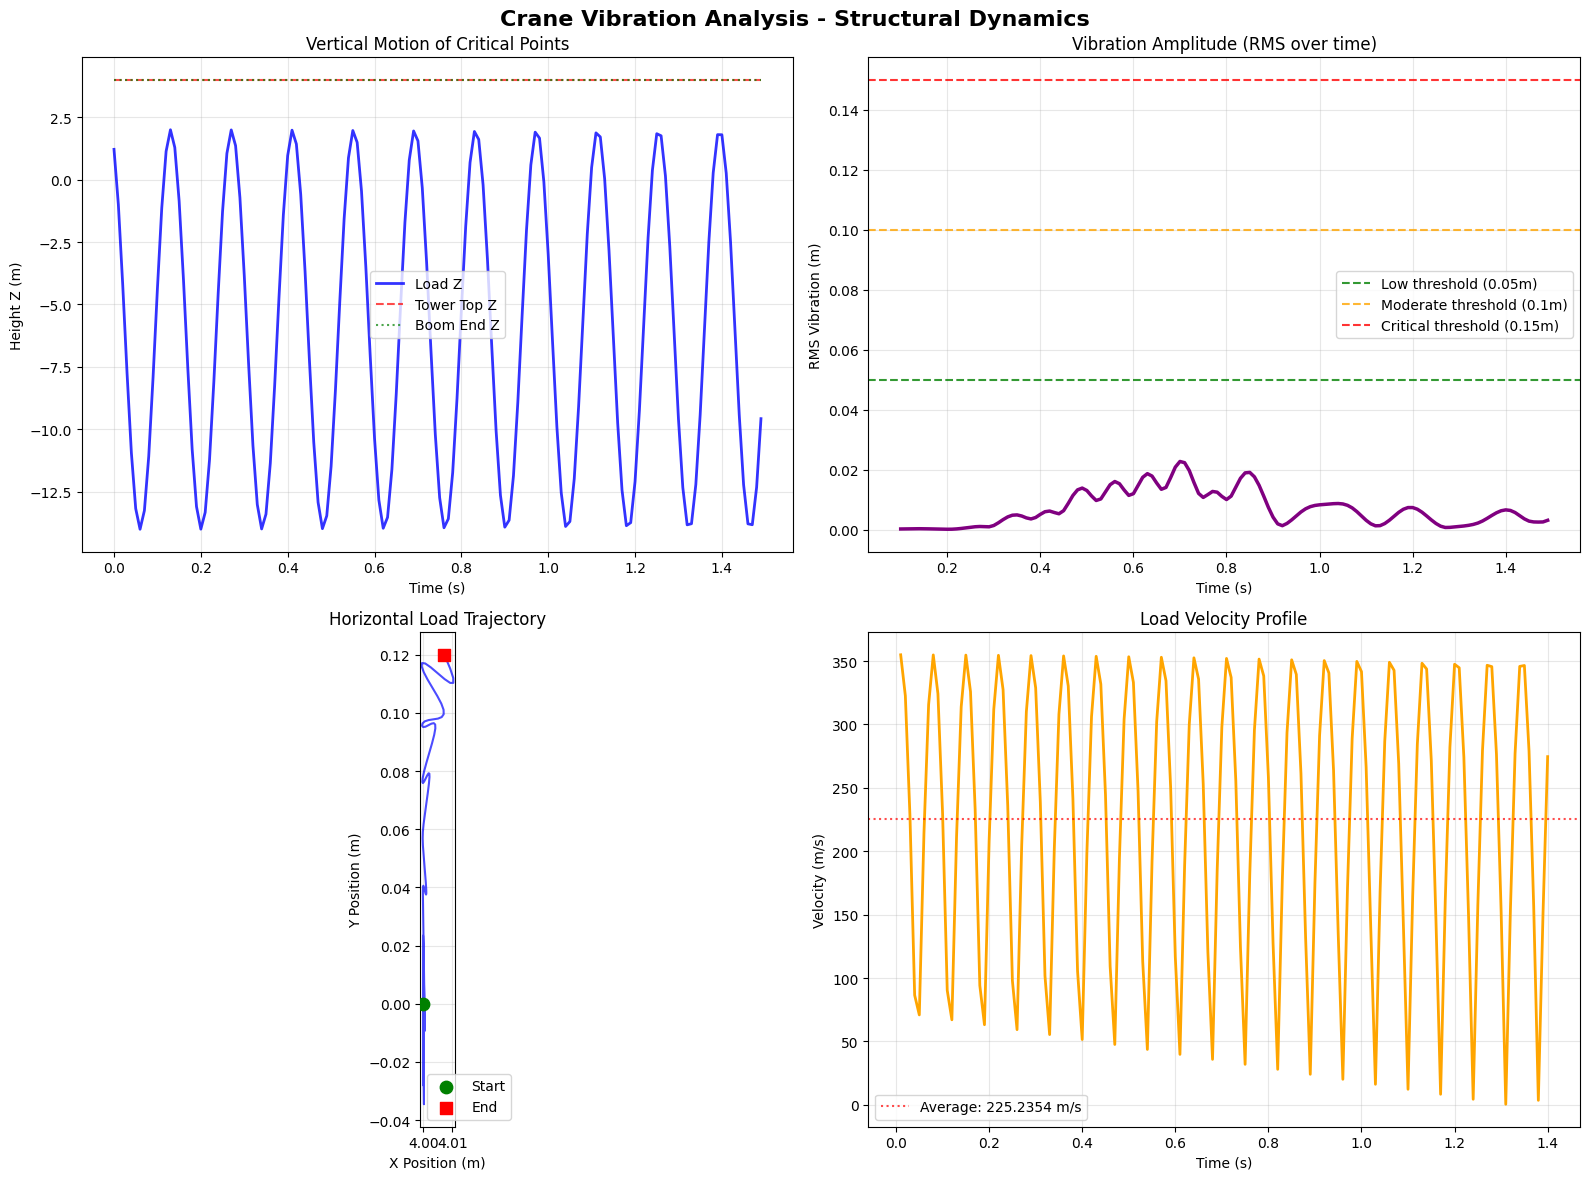


VIBRATION ANALYSIS - STRUCTURAL ASSESSMENT
Maximum vibration amplitude:    0.0227 m
Average vibration:              0.0069 m
Standard deviation:             0.0058 m

Vibration distribution (140 measurements):
  Low       (≤0.05m):   140 (100.0%)
  Moderate  (0.05-0.1m):   0 (  0.0%)
  High      (0.1-0.15m):   0 (  0.0%)
  Critical  (>0.15m):     0 (  0.0%)

Structural stability: EXCELLENT
Safety factor: Very high

Maximum velocity:        354.9622 m/s
Average velocity:        225.2354 m/s

Load motion range:
  X-direction: 0.0109 m
  Y-direction: 0.1545 m
  Z-direction: 16.0073 m

STRUCTURAL RECOMMENDATIONS:
   Structure shows excellent stability
   No special measures required


In [6]:
# Vibration analysis and structural assessment
print("Analyzing crane vibration data...")

if len(load_positions) < 10:
    print("Insufficient data for analysis - need at least 10 data points")
else:
    # Convert data to arrays
    load_pos = np.array(load_positions)
    tower_pos = np.array(tower_top_positions) if tower_top_positions else None
    boom_pos = np.array(boom_end_positions) if boom_end_positions else None
    time = np.array(time_steps)

    # Create analysis plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Crane Vibration Analysis - Structural Dynamics', fontsize=16, fontweight='bold')

    # 1. Vertical motion analysis
    axes[0,0].plot(time, load_pos[:, 2], 'b-', linewidth=2, label='Load Z', alpha=0.8)
    if tower_pos is not None:
        axes[0,0].plot(time, tower_pos[:, 2], 'r--', linewidth=1.5, alpha=0.7, label='Tower Top Z')
    if boom_pos is not None:
        axes[0,0].plot(time, boom_pos[:, 2], 'g:', linewidth=1.5, alpha=0.7, label='Boom End Z')
    axes[0,0].set_xlabel('Time (s)')
    axes[0,0].set_ylabel('Height Z (m)')
    axes[0,0].set_title('Vertical Motion of Critical Points')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Vibration amplitude over time
    if displacement_amplitudes:
        vib_time = time[10:]
        axes[0,1].plot(vib_time, displacement_amplitudes, 'purple', linewidth=2.5)
        axes[0,1].axhline(y=0.05, color='green', linestyle='--', alpha=0.8, label='Low threshold (0.05m)')
        axes[0,1].axhline(y=0.1, color='orange', linestyle='--', alpha=0.8, label='Moderate threshold (0.1m)')
        axes[0,1].axhline(y=0.15, color='red', linestyle='--', alpha=0.8, label='Critical threshold (0.15m)')
        axes[0,1].set_xlabel('Time (s)')
        axes[0,1].set_ylabel('RMS Vibration (m)')
        axes[0,1].set_title('Vibration Amplitude (RMS over time)')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

    # 3. Horizontal trajectory (X-Y plot)
    axes[1,0].plot(load_pos[:, 0], load_pos[:, 1], 'b-', alpha=0.7, linewidth=1.5)
    axes[1,0].scatter(load_pos[0, 0], load_pos[0, 1], c='green', s=80, marker='o', label='Start', zorder=5)
    axes[1,0].scatter(load_pos[-1, 0], load_pos[-1, 1], c='red', s=80, marker='s', label='End', zorder=5)
    axes[1,0].set_xlabel('X Position (m)')
    axes[1,0].set_ylabel('Y Position (m)')
    axes[1,0].set_title('Horizontal Load Trajectory')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].set_aspect('equal')

    # 4. Velocity analysis
    if velocity_history:
        vel_time = time[1:len(velocity_history)+1]
        axes[1,1].plot(vel_time, velocity_history, 'orange', linewidth=2)
        axes[1,1].axhline(y=np.mean(velocity_history), color='red', linestyle=':', alpha=0.7, 
                         label=f'Average: {np.mean(velocity_history):.4f} m/s')
        axes[1,1].set_xlabel('Time (s)')
        axes[1,1].set_ylabel('Velocity (m/s)')
        axes[1,1].set_title('Load Velocity Profile')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistical evaluation
    print("\n" + "=" * 70)
    print("VIBRATION ANALYSIS - STRUCTURAL ASSESSMENT")
    print("=" * 70)
    
    if displacement_amplitudes:
        max_vib = max(displacement_amplitudes)
        avg_vib = np.mean(displacement_amplitudes)
        std_vib = np.std(displacement_amplitudes)
        
        print(f"Maximum vibration amplitude:    {max_vib:.4f} m")
        print(f"Average vibration:              {avg_vib:.4f} m")
        print(f"Standard deviation:             {std_vib:.4f} m")
        
        # Vibration categorization
        critical_count = sum(1 for v in displacement_amplitudes if v > 0.15)
        high_vib_count = sum(1 for v in displacement_amplitudes if 0.1 < v <= 0.15)
        mod_vib_count = sum(1 for v in displacement_amplitudes if 0.05 < v <= 0.1)
        low_vib_count = sum(1 for v in displacement_amplitudes if v <= 0.05)
        
        total_measurements = len(displacement_amplitudes)
        print(f"\nVibration distribution ({total_measurements} measurements):")
        print(f"  Low       (≤0.05m):   {low_vib_count:3d} ({100*low_vib_count/total_measurements:5.1f}%)")
        print(f"  Moderate  (0.05-0.1m): {mod_vib_count:3d} ({100*mod_vib_count/total_measurements:5.1f}%)")
        print(f"  High      (0.1-0.15m): {high_vib_count:3d} ({100*high_vib_count/total_measurements:5.1f}%)")
        print(f"  Critical  (>0.15m):   {critical_count:3d} ({100*critical_count/total_measurements:5.1f}%)")
        
        # Structural stability assessment
        if max_vib < 0.03:
            stability = "EXCELLENT"
            safety_factor = "Very high"
        elif max_vib < 0.07:
            stability = "GOOD"
            safety_factor = "High"
        elif max_vib < 0.12:
            stability = "ACCEPTABLE"
            safety_factor = "Moderate"
        elif max_vib < 0.2:
            stability = "CONCERNING"
            safety_factor = "Low"
        else:
            stability = "CRITICAL"
            safety_factor = "Very low"
            
        print(f"\nStructural stability: {stability}")
        print(f"Safety factor: {safety_factor}")
        
    if velocity_history:
        max_vel = max(velocity_history)
        avg_vel = np.mean(velocity_history)
        print(f"\nMaximum velocity:        {max_vel:.4f} m/s")
        print(f"Average velocity:        {avg_vel:.4f} m/s")
    
    # Load motion range
    load_range_x = load_pos[:, 0].max() - load_pos[:, 0].min()
    load_range_y = load_pos[:, 1].max() - load_pos[:, 1].min()
    load_range_z = load_pos[:, 2].max() - load_pos[:, 2].min()
    
    print(f"\nLoad motion range:")
    print(f"  X-direction: {load_range_x:.4f} m")
    print(f"  Y-direction: {load_range_y:.4f} m") 
    print(f"  Z-direction: {load_range_z:.4f} m")
    
    # Structural recommendations
    print(f"\nSTRUCTURAL RECOMMENDATIONS:")
    if max_vib < 0.05:
        print("   Structure shows excellent stability")
        print("   No special measures required")
    elif max_vib < 0.1:
        print("   Moderate vibrations detected")
        print("   Monitor critical connections recommended")
    else:
        print("   Elevated vibrations - structural analysis required")
        print("   Consider joint reinforcement or damping")
        
    print("=" * 70)
